In [15]:
#!pip install torch_geometric
#!pip install torch

In [16]:
import pandas as pd
import numpy as np
from torch_geometric.data import Data
import torch

In [17]:
folder = 'split_cleaned_dataset/'

train = pd.read_csv(folder+'train_september.csv').drop(columns=['Passengers In', 'Passengers Out', 'Actual Bus Occupancy', 'month_cos', 'month_sin'])
val = pd.read_csv(folder+'val_september.csv')
test = pd.read_csv(folder+'test_september.csv')

In [18]:
train.head()

,Route Name,stop_sequence_normalized,daily_order_trip_normalized,Horizontal Direction,Vertical Direction,hour_sin,hour_cos,minute_sin,minute_cos,day_sin,day_cos,weekday_sin,weekday_cos,stop_lat_norm,stop_lon_norm,Overcrowded
0,0.159385,0.0,1.0,1,0,-1.000000,0.000000,-0.406737,-0.913545,0.205863,0.978581,0.0,1.0,0.679239,0.191049,0
1,0.159385,0.5,1.0,1,0,-1.000000,0.000000,-0.994522,0.104528,0.205863,0.978581,0.0,1.0,0.758647,0.202937,0
2,0.159385,1.0,1.0,1,0,-1.000000,0.000000,-0.669131,0.743145,0.205863,0.978581,0.0,1.0,0.770613,0.227083,0
3,0.159385,0.0,0.2,-1,0,0.258819,-0.965926,0.743145,-0.669131,0.205863,0.978581,0.0,1.0,0.771116,0.226312,0
4,0.159385,0.5,0.2,-1,0,0.258819,-0.965926,0.104528,-0.994522,0.205863,0.978581,0.0,1.0,0.759909,0.201772,0


# Data Dictionary for a single month data:

* Route Name: Target encoded variable where each route name was replace using the following expression:

    $P(1|C) = \frac{\text{Count of 1's for category C} + \alpha}{\text{Total occurrences of category C} + 2\alpha}$ 

where C is the category, e.g: 1C, 1A, 115, and $\alpha$ is a small number to prevent probabilities to be too close to 0 or 1.

* stop_sequence_normalized: a value from 0 to 1 that indicates the position of the stop in the same route and same direction.
* daily_order_trip_normalized: a value from 0 to 1 that indicates the actual stage of the route in the day, if it is the first trip or second, or third, and so on. this is grouped by route, direction and arrival time of the stops at stop_sequence_normalized = 0 (this is called also the starting time). 
* Horizontal Direction: -1 if it is west, 1 if it is east, 0 if it is either north or south (meaining vertical direction route).
* Vertical Direction: -1 if it is south, 1 if it is north, 0 if it is either west or east (meaning a horizontal direction route).
* hour_sin: cyclical encoding for hour, sin value 
* hour_cos: cyclical encoding for hour, cos value
* minute_sin: cyclical encoding for minute, sin value
* minute_cos: cyclical encoding for minute, cos value
* day_sin: cyclical encoding for day, sin value
* day_cos: cyclical encoding for day, cos value
* weekday_sin: cyclical encoding for weekday, sin value (starting at sunday)
* weekday_cos: cyclical encoding for weekday, cos value (starting at sunday)
* stop_lat_norm: closest avalue to ecuator line is 0, closest value to north pole is 1 
* stop_lon_norm: farleft value is 0 and farright value is 1.
* Overcrowded: binary value where 1 means that it was overcrowded (more than 35 people inside the bus), and 0 no overcrowded

# Create Adjency Matrix to build the route shapes
### What is an Adjency shape and why is ti useful for this kind of models?
An adjacency matrix (A) is a mathematical representation of the connections between nodes in a graph. It tells the model which nodes are connected (and optionally how strong or directed that connection is).

The model will learn within-trip patterns, e.g., "If Stop A is crowded, what’s the chance the next stops will also be?"

### 📚 References
Wu, Z., Pan, S., Chen, F., Long, G., Zhang, C., & Yu, P. S. (2021). **A Comprehensive Survey on Graph Neural Networks**. *IEEE Transactions on Neural Networks and Learning Systems*, *32*(1), 4–24. https://doi.org/10.1109/TNNLS.2020.2978386


In [19]:
import pandas as pd
import numpy as np

def build_adjacency_per_trip(df):
    """
    Builds adjacency matrices for each trip in the dataset based on route, direction, day, and trip_id.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing the necessary columns:
            - 'Route Name', 'Horizontal Direction', 'Vertical Direction'
            - 'day_sin', 'day_cos', 'daily_order_trip_normalized', 'stop_sequence_normalized'
    
    Returns:
        adjacency_matrices (list of dicts): 
            Each dict contains the adjacency matrix and trip metadata.
    """
    group_cols = [
        'Route Name', 'Horizontal Direction', 'Vertical Direction', 'day_sin', 'day_cos'
    ]

    # Create trip_id by ranking trips within each group
    df = df.copy()
    df['trip_id'] = df.groupby(group_cols)['daily_order_trip_normalized'].rank(method='dense').astype(int)

    adjacency_matrices = []

    # Iterate over each unique trip
    for (route, h_dir, v_dir, day_sin, day_cos, trip_id), trip_df in df.groupby(group_cols + ['trip_id']):
        # Sort stops by stop_sequence within the trip
        trip_df_sorted = trip_df.sort_values(by='stop_sequence_normalized').reset_index(drop=True)
        N = len(trip_df_sorted)
        A = np.zeros((N, N))

        # Connect stops sequentially
        for i in range(N - 1):
            A[i, i + 1] = 1
        np.fill_diagonal(A, 1)  # Optional: Add self-loops

        adjacency_matrices.append({
            'route': route,
            'h_dir': h_dir,
            'v_dir': v_dir,
            'day_sin': day_sin,
            'day_cos': day_cos,
            'trip_id': trip_id,
            'adjacency': A,
            'trip_stops': trip_df_sorted
        })

    print(f"✅ Total Trips Processed: {len(adjacency_matrices):,}")
    print("Sample Adjacency Matrix Shape:", adjacency_matrices[0]['adjacency'].shape)
    return adjacency_matrices


In [20]:
from torch_geometric.data import Data

def build_graph_data(adjacency_matrices):
    """
    Converts the adjacency + stop info from each trip into PyTorch Geometric Data objects.
    """
    graph_list = []

    for trip in adjacency_matrices:
        df = trip['trip_stops']
        A = trip['adjacency']
        edge_index = torch.tensor(np.array(A).nonzero(), dtype=torch.long)

        # Define your feature columns (same as your earlier node_features)
        feature_columns = [
            'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
            'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos',
            'stop_lat_norm', 'stop_lon_norm',
            'Horizontal Direction', 'Vertical Direction',
            'stop_sequence_normalized', 'Route Name', 'daily_order_trip_normalized'
        ]
        
        x = torch.tensor(df[feature_columns].values, dtype=torch.float)
        y = torch.tensor(df['Overcrowded'].values, dtype=torch.long)

        graph = Data(x=x, edge_index=edge_index, y=y)
        graph_list.append(graph)

    print(f"✅ Graphs created: {len(graph_list)}")
    return graph_list


In [21]:
train_adjacency_list = build_adjacency_per_trip(train)
val_adjacency_list = build_adjacency_per_trip(val)
test_adjacency_list = build_adjacency_per_trip(test)

#Lat Min: 42.042087, Lat Max: 42.34243354, Lon Min: -83.114924, Lon Max: -82.606767

✅ Total Trips Processed: 3,140
Sample Adjacency Matrix Shape: (4, 4)
✅ Total Trips Processed: 896
Sample Adjacency Matrix Shape: (4, 4)
✅ Total Trips Processed: 450
Sample Adjacency Matrix Shape: (4, 4)


In [22]:
import torch
from torch_geometric.data import Data

def build_graph_data_from_adjacency_list(adjacency_list):
    """
    Converts the output from build_adjacency_per_trip into PyTorch Geometric Data objects.
    
    Each trip becomes a graph with:
    - x: node features
    - edge_index: connectivity (from adjacency matrix)
    - y: target labels per node (Overcrowded)
    """
    graph_list = []

    for trip in adjacency_list:
        trip_df = trip['trip_stops']

        # Node features
        feature_columns = [
            'hour_sin', 'hour_cos',
            'minute_sin', 'minute_cos',
            'day_sin', 'day_cos',
            'weekday_sin', 'weekday_cos',
            'stop_lat_norm', 'stop_lon_norm',
            'Horizontal Direction', 'Vertical Direction',
            'stop_sequence_normalized',
            'Route Name',
            'daily_order_trip_normalized'
        ]
        x = torch.tensor(trip_df[feature_columns].values, dtype=torch.float)

        # Labels (binary class per stop)
        y = torch.tensor(trip_df['Overcrowded'].values, dtype=torch.long)

        # Edge index from adjacency matrix (nonzero gives COO format)
        A = trip['adjacency']
        edge_index = torch.tensor(np.array(A).nonzero(), dtype=torch.long)

        # Build the graph object
        data = Data(x=x, edge_index=edge_index, y=y)
        graph_list.append(data)

    print(f"✅ Total graphs created: {len(graph_list)}")
    return graph_list


In [23]:
train_graphs = build_graph_data_from_adjacency_list(train_adjacency_list)
val_graphs = build_graph_data_from_adjacency_list(val_adjacency_list)
test_graphs = build_graph_data_from_adjacency_list(test_adjacency_list)


✅ Total graphs created: 3140
✅ Total graphs created: 896
✅ Total graphs created: 450


# Model Implementation

In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class OvercrowdingGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(OvercrowdingGCN, self).__init__()
        
        # First GCN layer: input features to hidden
        self.conv1 = GCNConv(input_dim, hidden_dim)
        
        # Second GCN layer: hidden to output (2 classes: Overcrowded / Not)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        # GCN Layer 1 + ReLU
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        # GCN Layer 2 (output logits)
        x = self.conv2(x, edge_index)
        
        return x  # Outputs logits per node


In [25]:
from torch_geometric.loader import DataLoader

batch_size = 32
# # Create DataLoader for training (adjust batch_size based on memory)
# train_loader = DataLoader(train_node_features, batch_size=batch_size, shuffle=True)

# # (Optional) Do the same for validation/test sets
# val_loader = DataLoader(val_node_features, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_node_features, batch_size=batch_size, shuffle=False)

from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32)
test_loader = DataLoader(test_graphs, batch_size=32)


In [26]:
# Safely extract one batch to get input feature size
first_batch = next(iter(train_loader))
input_dim = first_batch.x.shape[1]

hidden_dim = 64
output_dim = 2  # Binary classification (Overcrowded / Not)

model = OvercrowdingGCN(input_dim, hidden_dim, output_dim)


for batch in train_loader:
    out = model(batch.x, batch.edge_index, batch.batch)  # Example call


In [27]:
from sklearn.metrics import precision_score, recall_score

model.eval()
val_loss = 0
all_preds = []
all_targets = []

criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for batch in val_loader:
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        val_loss += loss.item()

        preds = out.argmax(dim=1)  # Predicted class (0 or 1)

        all_preds.append(preds.cpu())    # Store predictions
        all_targets.append(batch.y.cpu())  # Store true labels

# Concatenate all predictions and targets
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

# ✅ Compute Precision and Recall per class
precision_class_0 = precision_score(all_targets, all_preds, pos_label=0, zero_division=0)
recall_class_0 = recall_score(all_targets, all_preds, pos_label=0, zero_division=0)

precision_class_1 = precision_score(all_targets, all_preds, pos_label=1, zero_division=0)
recall_class_1 = recall_score(all_targets, all_preds, pos_label=1, zero_division=0)

print(f"✅ Validation Loss: {val_loss:,.2f}")
print(f"🎯 Class 0 (Not Overcrowded) - Precision: {precision_class_0:.2%}, Recall: {recall_class_0:.2%}")
print(f"🚨 Class 1 (Overcrowded) - Precision: {precision_class_1:.2%}, Recall: {recall_class_1:.2%}")


✅ Validation Loss: 30.54
🎯 Class 0 (Not Overcrowded) - Precision: 79.33%, Recall: 4.91%
🚨 Class 1 (Overcrowded) - Precision: 10.41%, Recall: 89.62%


# Model with random search

In [52]:
import random
from torch_geometric.loader import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Define a model class
class OvercrowdingGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout, num_layers=4):
        super(OvercrowdingGCN, self).__init__()
        self.dropout = dropout
        self.layers = nn.ModuleList()
        self.layers.append(GCNConv(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_dim, hidden_dim))
        self.output_layer = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            x = F.relu(x)
            if i > 0:
                x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.output_layer(x, edge_index)
        return x



def random_from_range(min_val, max_val, step=None, num_samples=None):
    if step:
        values = np.arange(min_val, max_val + step, step)
    elif num_samples:
        values = np.linspace(min_val, max_val, num_samples)
    else:
        raise ValueError("Provide either 'step' or 'num_samples'")
    return random.choice(values)

def random_class_weight_range(min_w0, max_w0, min_w1, max_w1, num_samples=5):
    w0 = random.uniform(min_w0, max_w0)
    w1 = random.uniform(min_w1, max_w1)
    return torch.tensor([w0, w1]).float()

def random_search(train_loader, val_loader, input_dim, output_dim, trials=10, epochs=3):
    search_results = []
    best_precision_so_far = 0.0  # Track best precision score across trials

    for trial in tqdm(range(trials), desc="Random Search Trials"):
        # Random hyperparameters
        hidden_dim = random.choice([64, 128, 256, 512])
        lr = random_from_range(0.01, 0.2, num_samples=100)
        weight_decay = random_from_range(0, 0.5, num_samples=100)
        dropout = random_from_range(0.2, 0.4, step=0.001)
        class_weights = random_class_weight_range(0.1, 2, 0.5, 2.5, num_samples=100)
        num_layers = random_from_range(1, 11, step=1)

        # Model setup
        model = OvercrowdingGCN(input_dim, hidden_dim, output_dim, dropout, num_layers=num_layers)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

        # 🔁 Training
        model.train()
        for _ in range(epochs):
            for batch in train_loader:
                optimizer.zero_grad()
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = criterion(out, batch.y)
                loss.backward()
                optimizer.step()

        # 🧪 Validation
        model.eval()
        all_preds, all_targets, val_loss = [], [], 0
        with torch.no_grad():
            for batch in val_loader:
                out = model(batch.x, batch.edge_index, batch.batch)
                val_loss += criterion(out, batch.y).item()
                preds = out.argmax(dim=1)
                all_preds.append(preds.cpu())
                all_targets.append(batch.y.cpu())

        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)

        # 📊 Metrics
        precision_1 = precision_score(all_targets, all_preds, pos_label=1, zero_division=0)
        recall_1 = recall_score(all_targets, all_preds, pos_label=1, zero_division=0)
        f1_1 = f1_score(all_targets, all_preds, pos_label=1, zero_division=0)

        # Save result
        result = {
            'trial': trial + 1,
            'hidden_dim': hidden_dim,
            'lr': lr,
            'weight_decay': weight_decay,
            'dropout': dropout,
            'class_weights': class_weights.tolist(),
            'val_loss': val_loss,
            'precision_class_1': precision_1,
            'recall_class_1': recall_1,
            'f1_class_1': f1_1,
            'num_layers': num_layers
        }
        search_results.append(result)

        #print(f"Current Precision: {best_precision_so_far:.2%}")
        # 🏆 Print running best
        if precision_1 > best_precision_so_far:
            best_precision_so_far = precision_1
            print(f" 🌟 New Best Precision at Trial {trial + 1}: {precision_1:.4f}\n")

    df_results = pd.DataFrame(search_results)
    best_trial = df_results.loc[df_results['precision_class_1'].idxmax()]
    print("\n✅ Best Trial Based on Precision Score for Class 1 (Overcrowded):")
    print(best_trial)

    return df_results, best_trial

In [62]:
results, best_trial = random_search(train_loader, val_loader, input_dim, output_dim, trials=100, epochs=3)

Random Search Trials:   1%|          | 1/100 [00:00<01:15,  1.31it/s]

 🌟 New Best Precision at Trial 1: 0.1097



Random Search Trials:  30%|███       | 30/100 [03:49<04:48,  4.13s/it]

 🌟 New Best Precision at Trial 30: 0.6132



Random Search Trials: 100%|██████████| 100/100 [13:18<00:00,  7.99s/it]


✅ Best Trial Based on Precision Score for Class 1 (Overcrowded):
trial                                                     30
hidden_dim                                               256
lr                                                  0.027273
weight_decay                                        0.005051
dropout                                                0.369
class_weights        [1.041695237159729, 1.3871665000915527]
val_loss                                           10.600102
precision_class_1                                   0.613208
recall_class_1                                      0.060454
f1_class_1                                          0.110058
num_layers                                                 2
Name: 29, dtype: object


In [63]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Unpack best trial hyperparameters
best_model = OvercrowdingGCN(
    input_dim=input_dim,
    hidden_dim=best_trial['hidden_dim'],
    output_dim=output_dim,
    dropout=best_trial['dropout'],
    num_layers=best_trial.get('num_layers', 4)  # Fallback to 4 if not present
)

optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_trial['lr'],
    weight_decay=best_trial['weight_decay']
)

# Example if you stored optimizer too
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(best_trial['class_weights']).float())

# ✅ Train for n epochs
epochs = 30
best_model.train()
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        out = best_model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

# Optional re-train (quick) or load saved model
model.eval()
all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for batch in val_loader:
        out = model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1)[:, 1]  # Probabilities for class 1 (Overcrowded)
        all_probs.append(probs.cpu())
        all_preds.append(out.argmax(dim=1).cpu())
        all_targets.append(batch.y.cpu())

all_probs = torch.cat(all_probs).numpy()
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()


In [64]:
from sklearn.metrics import precision_score

precision_per_epoch = []

best_model.train()
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        out = best_model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

    # 🔍 Evaluate precision after this epoch
    best_model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in val_loader:
            out = best_model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(batch.y.cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    precision = precision_score(all_targets, all_preds, pos_label=1, zero_division=0)
    precision_per_epoch.append(precision)
    #print(f"Epoch {epoch+1:02d} ➤ Precision (class 1): {precision:.4f}")


In [65]:
val_loss_per_epoch = []

for epoch in range(epochs):
    best_model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = best_model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

    # 🔍 Compute validation loss after epoch
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            out = best_model(batch.x, batch.edge_index, batch.batch)
            val_loss += criterion(out, batch.y).item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_per_epoch.append(avg_val_loss)
    #print(f"Epoch {epoch+1:02d} ➤ Validation Loss: {avg_val_loss:.4f}")



/var/folders/dr/j7qs35_j4l1g20mfrlbns8hm0000gn/T/ipykernel_7180/1407433442.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


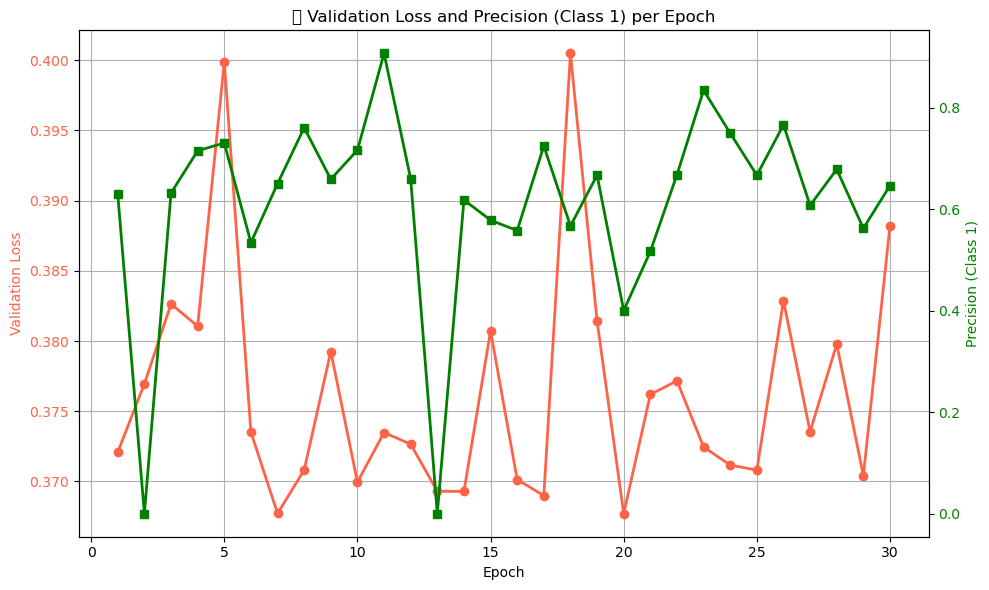

In [66]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# 🔵 Plot validation loss (left y-axis)
ax1.plot(range(1, epochs+1), val_loss_per_epoch, color='tomato', marker='o', label='Validation Loss', linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss", color='tomato')
ax1.tick_params(axis='y', labelcolor='tomato')
ax1.grid(True)

# 🟢 Create second y-axis for precision
ax2 = ax1.twinx()
ax2.plot(range(1, epochs+1), precision_per_epoch, color='green', marker='s', label='Precision (Class 1)', linewidth=2)
ax2.set_ylabel("Precision (Class 1)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 🏷️ Title & layout
plt.title("📊 Validation Loss and Precision (Class 1) per Epoch")
fig.tight_layout()
plt.show()



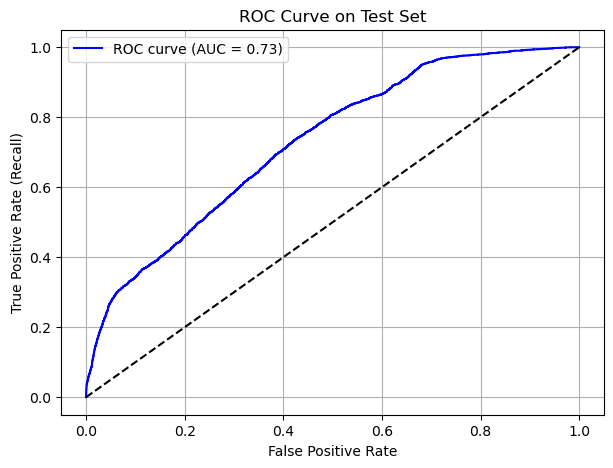

In [67]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Make sure model is in eval mode
best_model.eval()

all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in test_loader:
        out = best_model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1)[:, 1]  # Probabilities for class 1
        all_test_probs.append(probs.cpu())
        all_test_targets.append(batch.y.cpu())

# Concatenate
all_test_probs = torch.cat(all_test_probs).numpy()
all_test_targets = torch.cat(all_test_targets).numpy()

# ROC Curve
fpr, tpr, _ = roc_curve(all_test_targets, all_test_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve on Test Set')
plt.legend()
plt.grid(True)
plt.show()


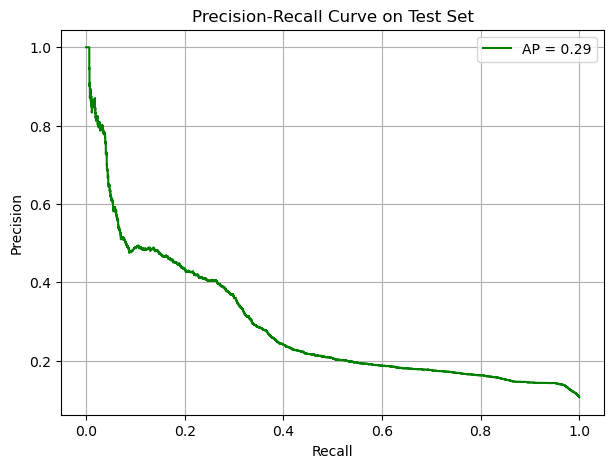

In [68]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 🧪 Evaluate on test set
best_model.eval()

all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in test_loader:
        out = best_model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1)[:, 1]  # Probabilities for class 1
        all_test_probs.append(probs.cpu())
        all_test_targets.append(batch.y.cpu())

# Concatenate
all_test_probs = torch.cat(all_test_probs).numpy()
all_test_targets = torch.cat(all_test_targets).numpy()

# 🎯 Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(all_test_targets, all_test_probs, pos_label=1)
avg_precision = average_precision_score(all_test_targets, all_test_probs)

# 📈 Plot the curve
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, color='green', label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Test Set')
plt.legend()
plt.grid(True)
plt.show()


In [69]:
from sklearn.metrics import precision_score

# 🎯 Compute final precision on test set predictions
final_precision = precision_score(all_test_targets, (all_test_probs >= 0.5).astype(int), pos_label=1, zero_division=0)

print(f"\n✅ Precision (Class 1 - Overcrowded) on Test Set: {final_precision:.2%}")

# 📋 Display best hyperparameters
print("\n✅ Best Hyperparameters from Random Search:")
print(best_trial)



✅ Precision (Class 1 - Overcrowded) on Test Set: 80.26%

✅ Best Hyperparameters from Random Search:
trial                                                     30
hidden_dim                                               256
lr                                                  0.027273
weight_decay                                        0.005051
dropout                                                0.369
class_weights        [1.041695237159729, 1.3871665000915527]
val_loss                                           10.600102
precision_class_1                                   0.613208
recall_class_1                                      0.060454
f1_class_1                                          0.110058
num_layers                                                 2
Name: 29, dtype: object


In [ ]:
from sklearn.metrics import classification_report

# 🎯 Binarize predictions from probability threshold (default = 0.5)
test_preds = (all_test_probs >= 0.5).astype(int)

# 🧾 Print classification report
print("📊 Classification Report (Test Set):\n")
print(classification_report(all_test_targets, test_preds, target_names=["Not Overcrowded", "Overcrowded"]))
